In [1]:

import numpy as np

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

from importlib import reload

import lina

dm_diam = 10.2*u.mm
dm_pupil_diam = 9.6*u.mm
dm_fill_factor = (dm_pupil_diam/dm_pupil_diam).decompose().value

lyot_pupil_diam = 9.6*u.mm
lyot_stop_diam = 8.7*u.mm

lyot_stop_ratio = (lyot_stop_diam/lyot_pupil_diam).decompose().value


Jax available; Jax model can be used.


Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


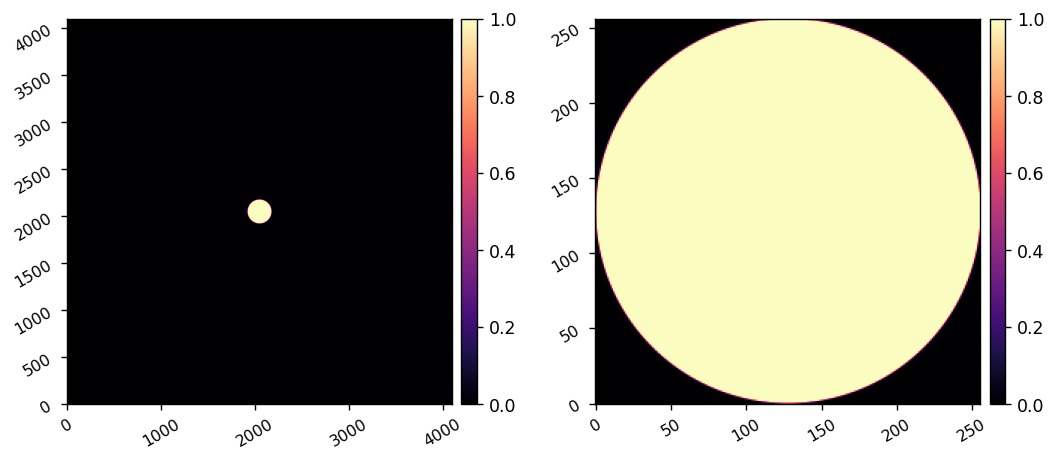

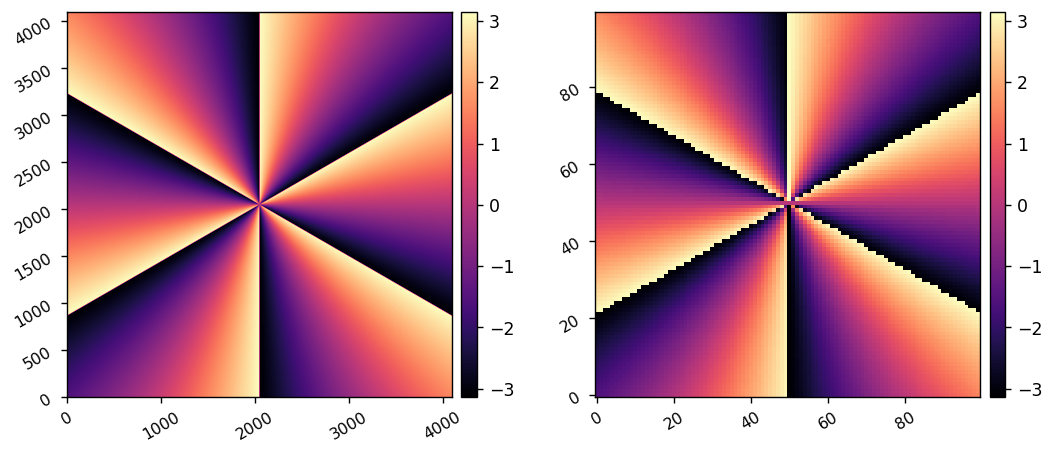

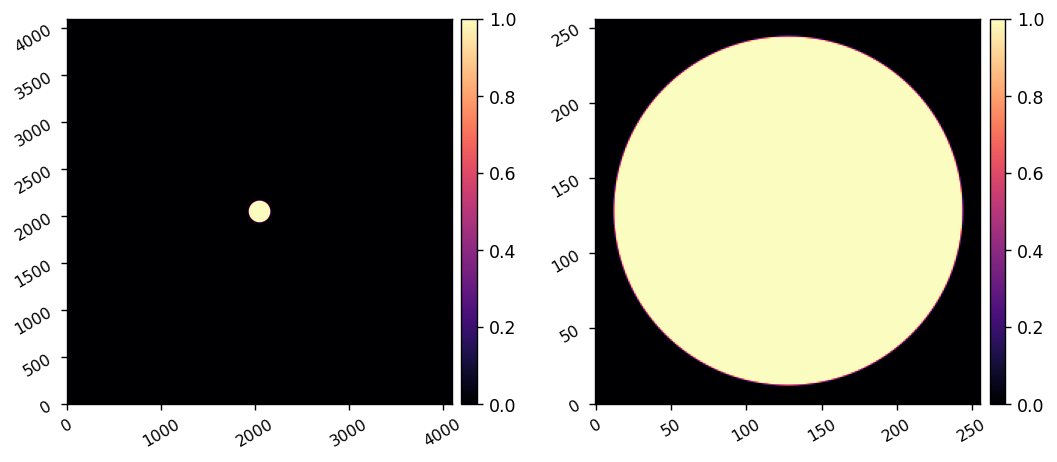

In [13]:
reload(cscoob)
reload(dm)

npix = 256
oversample = 16

model = cscoob.SCOOB(npix=npix, oversample=oversample, psf_pixelscale_lamD=1/5)

wf = poppy.FresnelWavefront(beam_radius=dm_pupil_diam/2, npix=model.npix, oversample=model.oversample)
model.PUPIL = poppy.CircularAperture(radius=dm_pupil_diam/2).get_transmission(wf)
imshow2(model.PUPIL, model.PUPIL, npix2=model.npix)

model.WFE = None

VORTEX = cscoob.make_vortex_phase_mask(model.focal_grid_polar, charge=6, 
                                    #    singularity=20*u.um, 
                                       focal_length=500*u.mm, pupil_diam=model.dm_pupil_diam, wavelength=632.8*u.nm)
imshow2(xp.angle(VORTEX), xp.angle(scoobpsf.utils.pad_or_crop(VORTEX, 100)))

model.LYOT = poppy.CircularAperture(radius=model.lyot_stop_diam/2).get_transmission(wf)
imshow2(model.LYOT, model.LYOT, npix2=model.npix)

In [4]:
model.reset_dm()

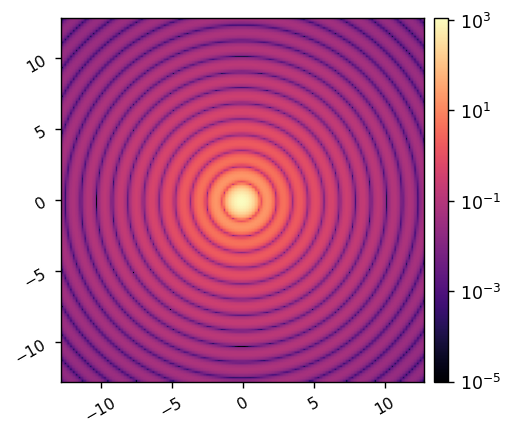

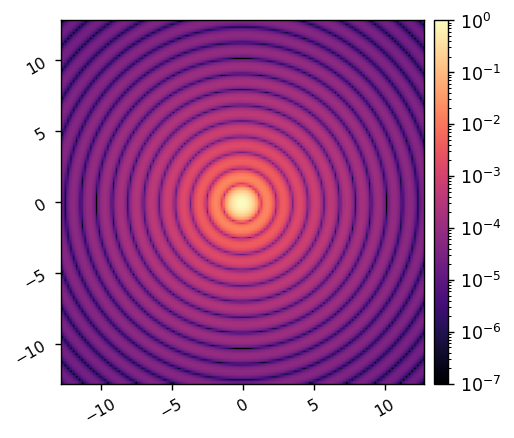

In [14]:
model.npsf = 128
model.FPM = None

model.reset_dm()

model.Imax_ref = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)

model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

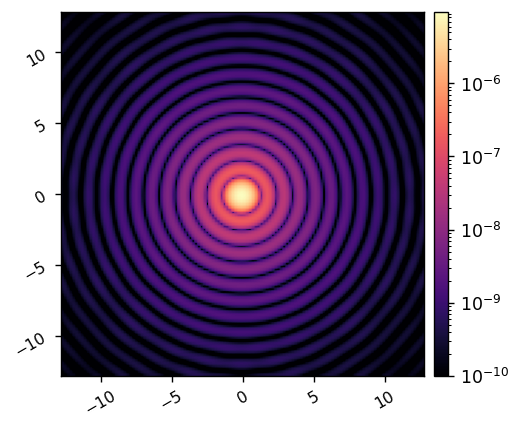

In [15]:
model.FPM = VORTEX

model.FIELDSTOP = None
# model.FIELDSTOP = model.focal_grid_pol[0]<15

image = model.snap(plot=True, vmin=1e-10)

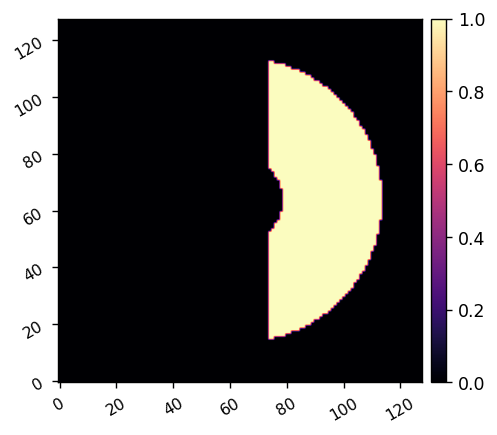

In [16]:
control_mask = lina.utils.create_annular_focal_plane_mask(model, 3, 10, 2, plot=True)

In [17]:
poke_modes = lina.utils.create_all_poke_modes(model.dm_mask)
calib_amp = 5e-9
response_matrix = lina.efc.calibrate(model, poke_modes, calib_amp, control_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=394.708 sec.
Jacobian built in 394.708 sec


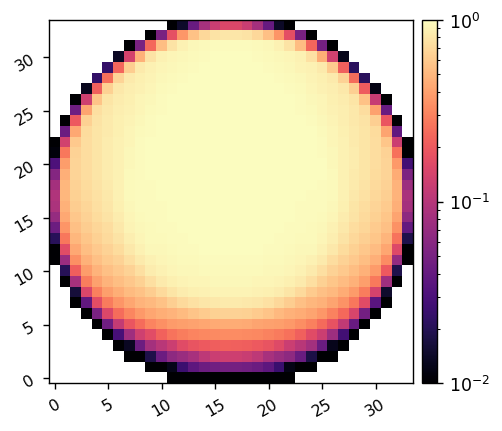

In [18]:
responses = response_matrix[::2] + 1j*response_matrix[1::2]
dm_response = xp.sqrt(xp.mean(xp.abs(responses.dot(xp.array(poke_modes)))**2, axis=0))
dm_response = dm_response.reshape(model.Nact, model.Nact)/xp.max(dm_response)

imshow1(dm_response, lognorm=True, vmin=1e-2)

In [19]:
utils.save_fits('jacobian.fits', response_matrix)

Saved data to:  jacobian.fits


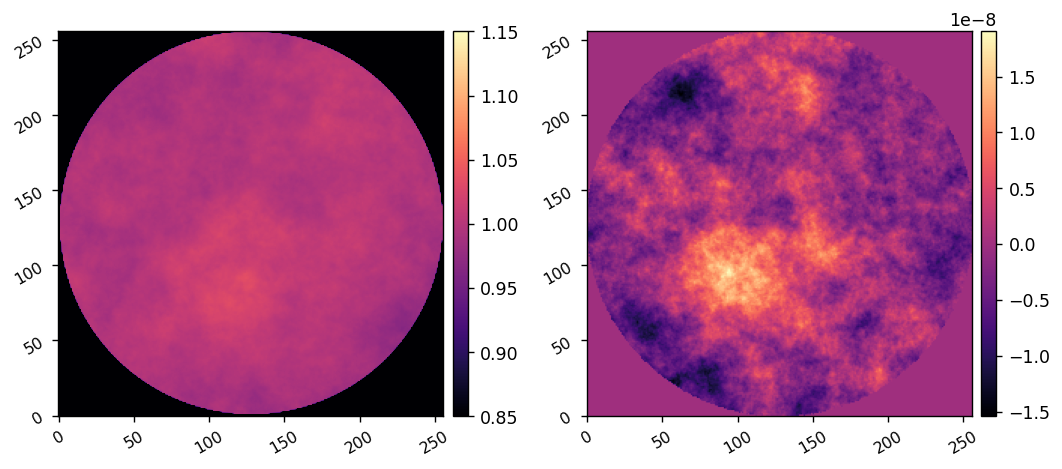

In [88]:
model.WFE = lina.utils.generate_wfe(model.pupil_diam, wavelength=500*u.nm,
                                    opd_index=2.75, amp_index=3.0, 
                                    opd_seed=1234, amp_seed=12345,
                                    opd_rms=17*u.nm, amp_rms=0.05,
                                    npix=model.npix, oversample=model.oversample,
                                    plot=True)


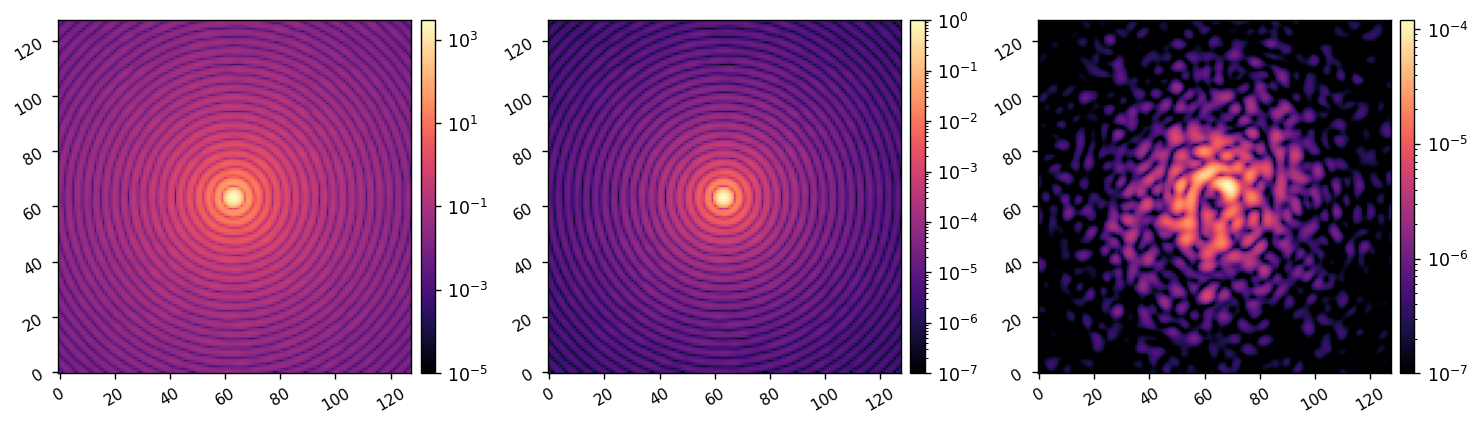

In [103]:
model.npsf = 128
model.FPM = None

model.reset_dm()

model.Imax_ref = None
raw_psf = model.snap()

model.Imax_ref = raw_psf.max()
ref_psf = model.snap()

model.FPM = VORTEX
ref_im = model.snap()

imshow3(raw_psf, ref_psf, ref_im, lognorm=True, vmin1=1e-5, vmin2=1e-7, vmin3=1e-9)

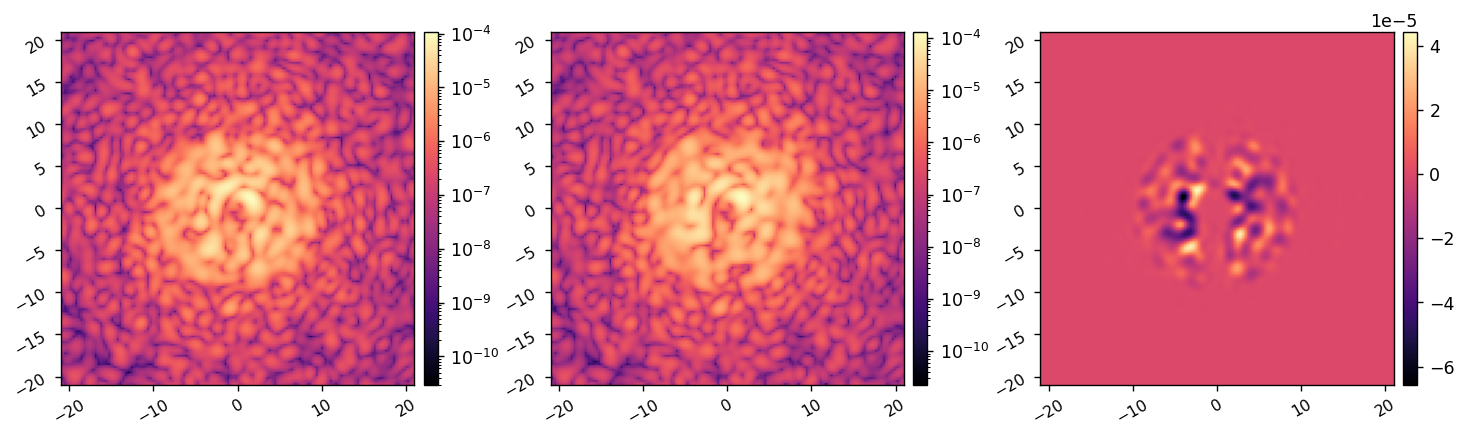

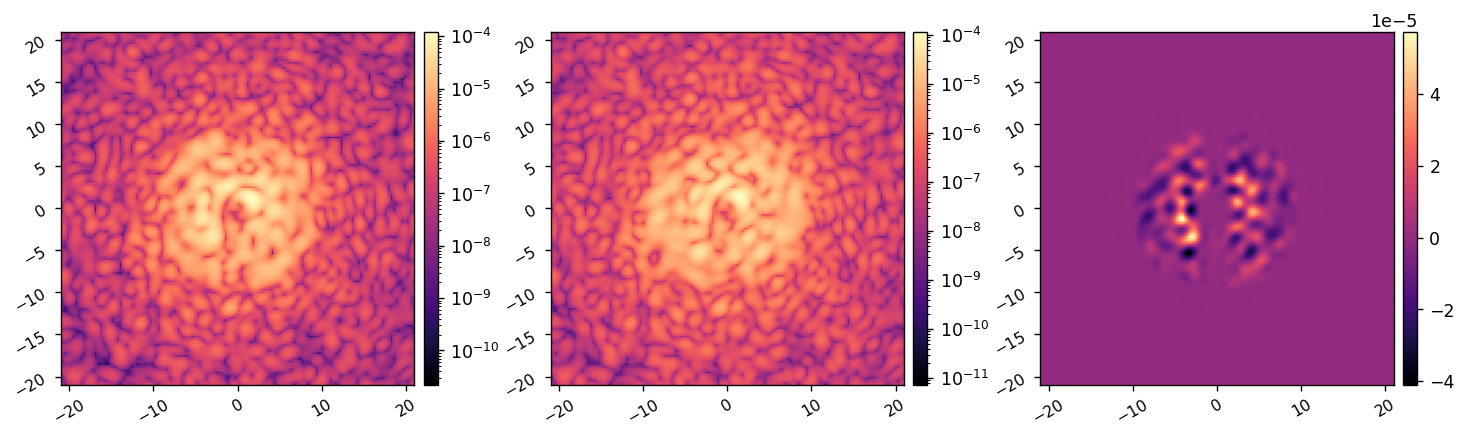

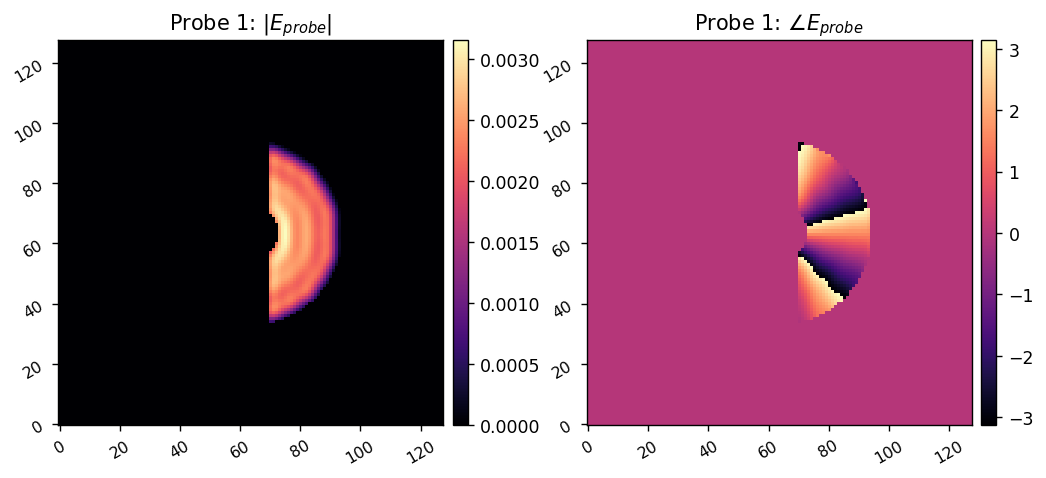

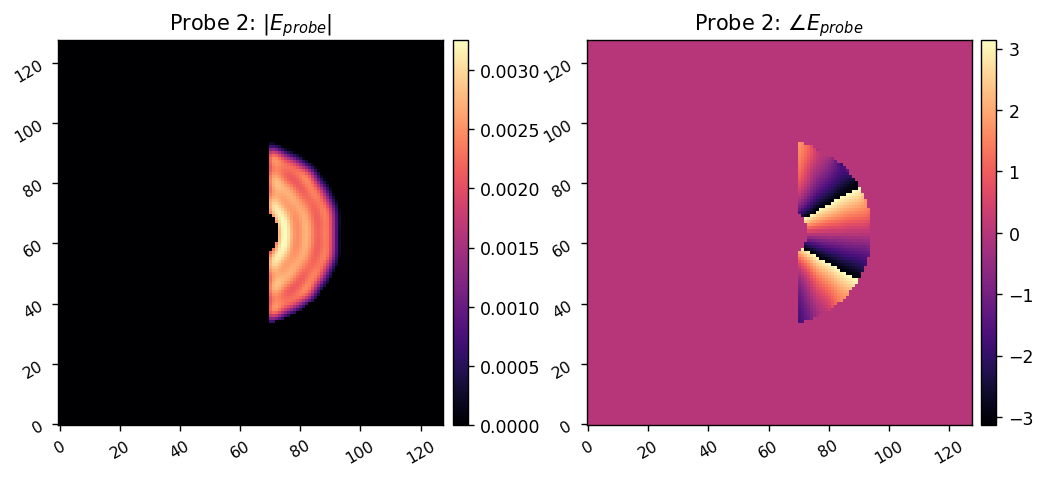

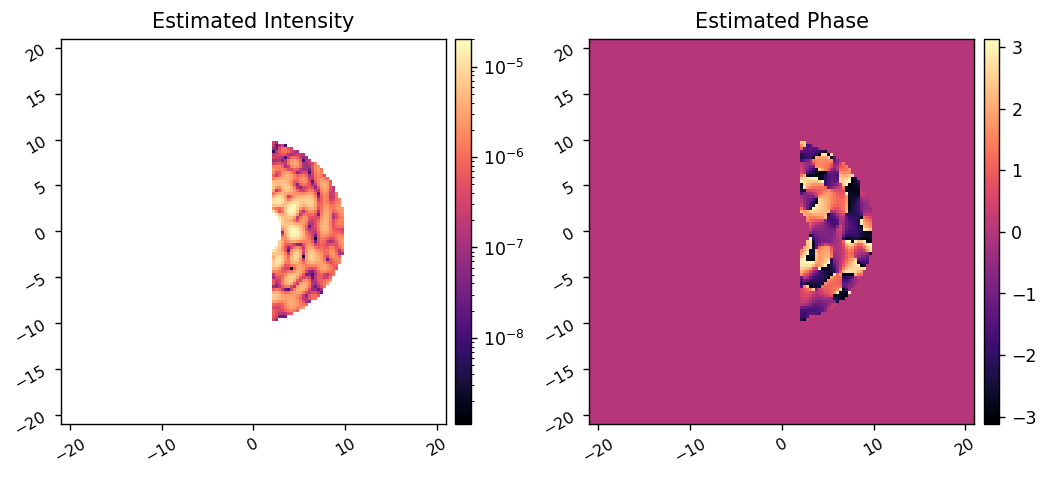

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [100]:
probe_amp = 10e-9
probe_modes = lina.utils.create_fourier_probes(model, control_mask, fourier_sampling=0.25, nprobes=2)
probes = probe_amp*probe_modes

lina.pwp.run_pwp_bp(model, control_mask, probes, use='J', jacobian=response_matrix, plot=True)


In [104]:
model.reset_dm()

images = xp.array([ref_im])
estimates = xp.array([])
dm_commands = xp.array([])

Beginning closed-loop EFC.
	Running iteration 1/3.
Using run_pwp_bp to estimate electric field


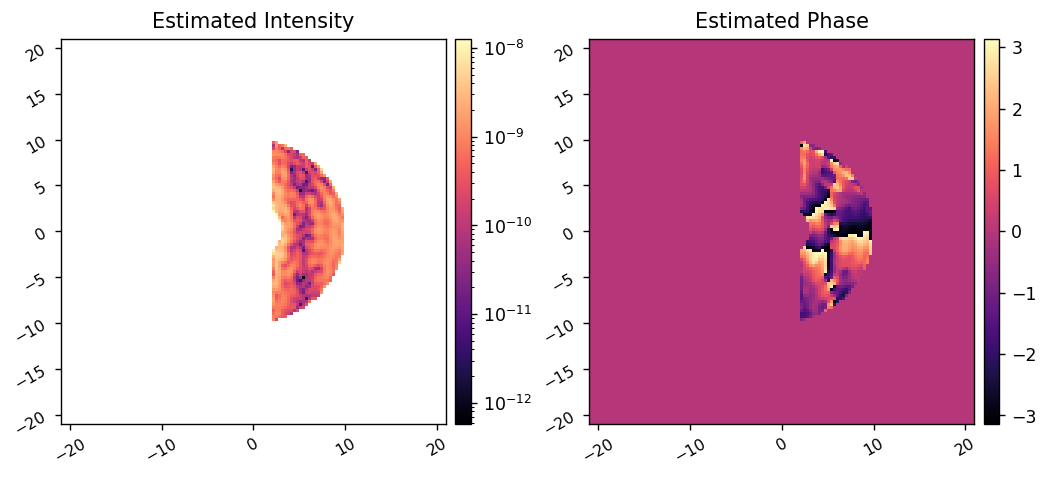

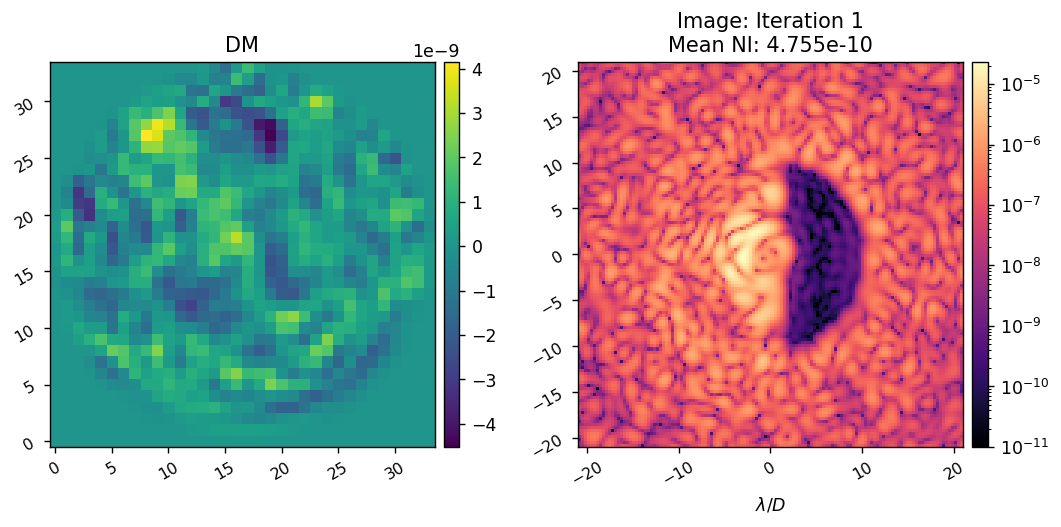

	Running iteration 2/3.
Using run_pwp_bp to estimate electric field


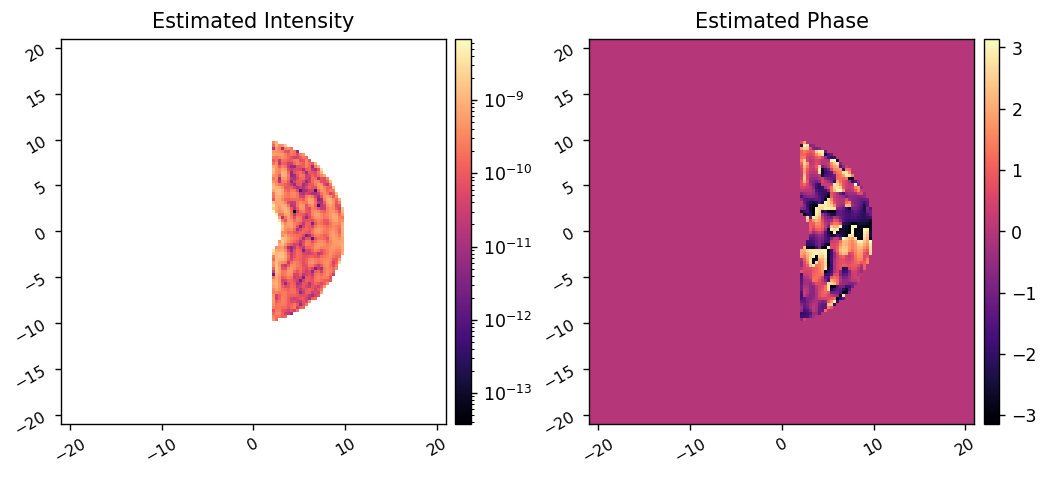

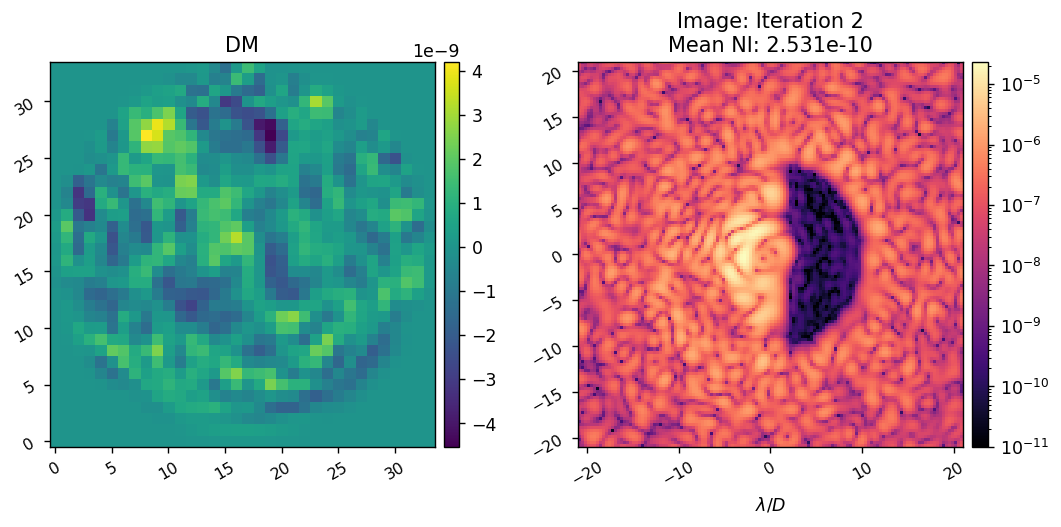

	Running iteration 3/3.
Using run_pwp_bp to estimate electric field


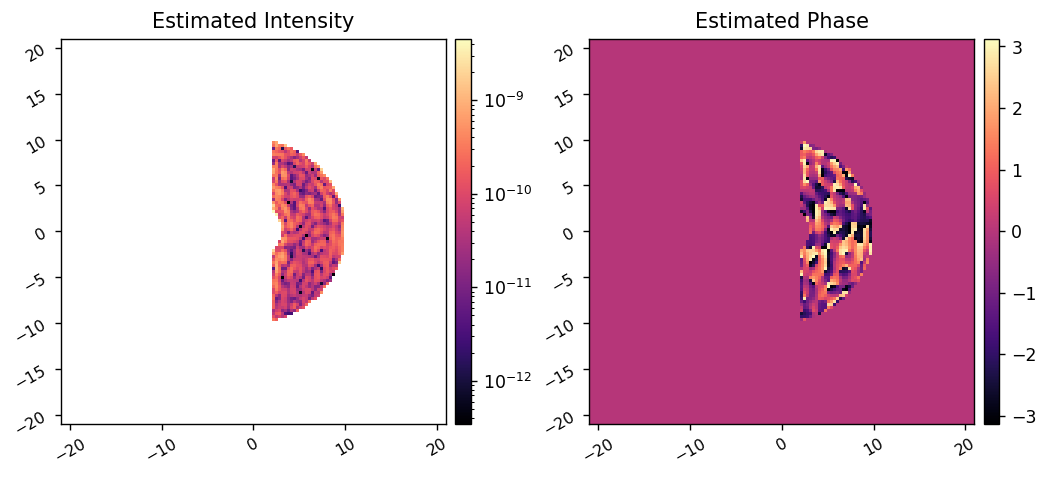

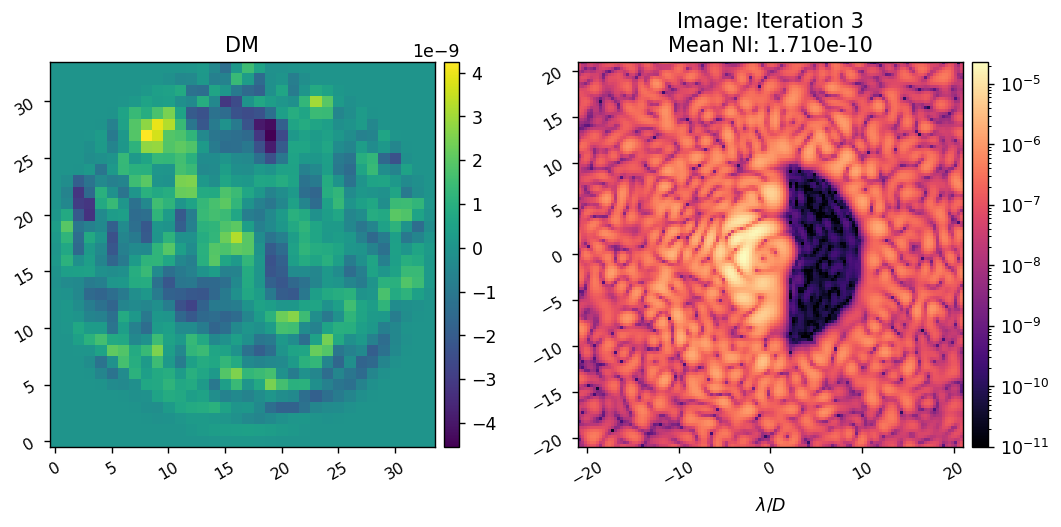

ValueError: All arrays to concatenate must have the same ndim

In [109]:
reload(lina.efc)

pwp_fun = lina.pwp.run_pwp_bp
probe_amp = 2e-9
pwp_params = {
    'probes':probe_amp*probe_modes,
    'control_mask':control_mask,
    'use':'J',
    'jacobian':response_matrix,
    'plot_est':True,
}

condition = -2
# condition = -4
control_matrix = lina.utils.beta_reg(response_matrix, condition)

images, estimates, dm_commands = lina.efc.run(model, 
                                              poke_modes,
                                              control_matrix,
                                              control_mask, 
                                              est_fun=pwp_fun,
                                              est_params=pwp_params,
                                              loop_gain=0.5, 
                                              leakage=0.0,
                                              iterations=3,
                                              plot_all=True,
                                              plot_current=True,
                                              plot_sms=False,
                                              plot_radial_contrast=False,
                                              old_images=images,
                                              old_fields=estimates,
                                              old_commands=dm_commands,
                                             )